In [18]:
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import model_from_json
from random import choice

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import seaborn as sn
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


# Implementing the model with a consortium of one vs. all classifiers

We trained five one vs. all binary classifiers to each identify a type of unwanted cell raft image. The training was done on DAPI staining and thus should be well generalizable to most mammalian cell line screens done using our code on the CellRaft platform. Here, as an example, we implement the model on a test set of images that we manually curated and know the ground truth of, to exhibit the model's performance

Below, enter the paths to the models

In [108]:
model_dir = 'models/'
bad_classes = ['artifacts_A','artifacts_B','lysed','bad_dense','outFocus']
models = {}
print("Loading models")
for i in tqdm(bad_classes):
    json_file = open(model_dir + i + '_model.json','r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_dir + i + '_weights.h5')
    models[i] = loaded_model
    print("Loaded model for: " + i)

Loading models


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

Loaded model for: artifacts_A
Loaded model for: artifacts_B
Loaded model for: lysed
Loaded model for: bad_dense
Loaded model for: outFocus



In [109]:
# Directory holding the test set of images
image_dir = 'example_images/'

def load_images():
    images = []
    for i in tqdm(os.listdir(image_dir)):
        if i == '.DS_Store':
            continue
        elif i == '.ipynb_checkpoints':
            continue
        else:
            path = os.path.join(image_dir,i)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            images.append(np.array(img))

    return images


In [110]:
image_list = load_images()

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

The following function will return a prediction given an image, a specific one vs. all model, and a prediction threshold

In [111]:
def predict(image, model, threshold):
    img = cv2.resize(image, (64,64))
    img = np.array(img).reshape(-1,64,64,1)
    model_out = model.predict([img])
    index = np.argmax(model_out)
    confidence = model_out[0][index]
    if index == 0:
        if confidence > threshold:
            in_class = True
        else:
            in_class = False
    else:
        in_class = False
        
    return in_class, confidence

The classify function combines all the one vs. all classifiers together into one model. Given an image and a dictionary of thresholds for each class, the function will return the classification of the image

In [112]:
def classify(image,thresholds):
    predictions = {}
    for n in bad_classes:
        in_class, confidence = predict(image, models[n], thresholds[n])
        if in_class == True:
            predictions[n] = confidence
        else:
            predictions[n] = 0
    cls = max(predictions, key=predictions.get)
    
    # case 1: multiple classifiers claim it, then it's just a bad image
    k = [key for (key,value) in predictions.items() if value == predictions[cls]]
    if len(k) > 1 and predictions[cls] != 0:
        classification = 'bad'
    # case 2: No bad class claims it; therefore it is good
    elif predictions[cls] == 0:
        classification = 'good'
    # case 3: One bad class claims it; assign it to that class
    else:
        classification = cls
        
    return classification

# Implement model

Set thresholds for each model. Here a binary classifier has to be more than 99% confident of an image being in-class to call it as such. Adjusting these parameters can help change false-positive/false-negative rates based on the desired outcome. For the sake of a genome-wide CRISPR screen, we'd rather have false positives than miss potential hits

In [113]:
thresholds = {'artifacts_A': 0.99,
             'artifacts_B': 0.99,
             'lysed': 0.99,
             'bad_dense': 0.99,
             'outFocus': 0.99}

Run all example images through the model

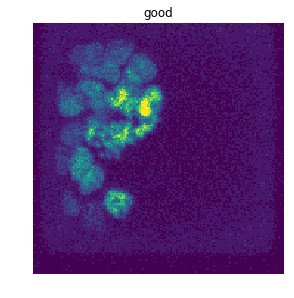

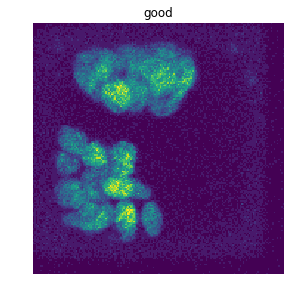

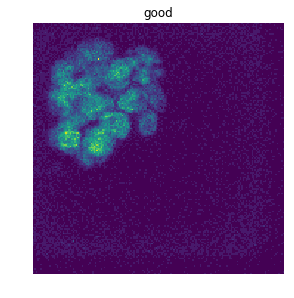

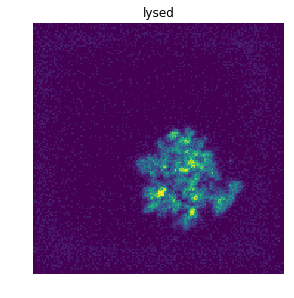

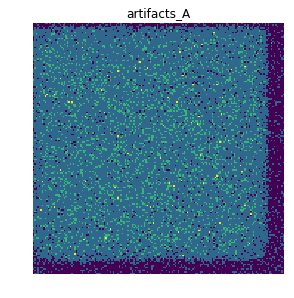

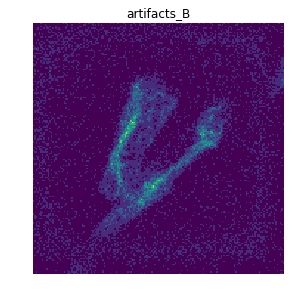

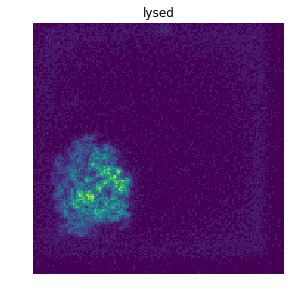

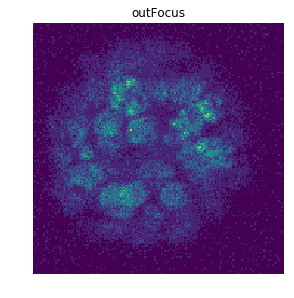

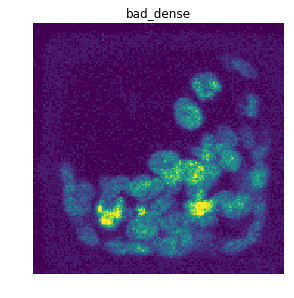

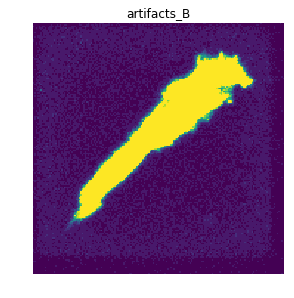

In [114]:
for i in range(len(image_list)):
    #image = choice(image_list)
    image = image_list[i]
    classification = classify(image,thresholds)
    plt.figure(figsize = (6,60))
    plt.subplot(11,1,i+1)
    plt.title(classification)
    plt.axis('off')
    plt.imshow(image,shape=(64,64))